# Method 6 - Best Minus Rest Top 5

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)
                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] <= 5].copy()                                                                                         
short_ideas = valid_data[valid_data['pos_rank'] > 5].copy()

# Weight the best ideas

long_ideas['target'] = long_ideas['target'] / long_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / long_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

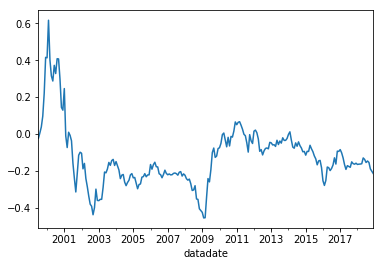

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.415927
2000-12-31   -0.202434
2001-12-31   -0.202167
2002-12-31   -0.290365
2003-12-31    0.296866
2004-12-31   -0.053311
2005-12-31   -0.008528
2006-12-31    0.009824
2007-12-31   -0.003234
2008-12-31   -0.253627
2009-12-31    0.574796
2010-12-31    0.156992
2011-12-31   -0.109747
2012-12-31    0.006493
2013-12-31    0.021809
2014-12-31   -0.071891
2015-12-31   -0.096846
2016-12-31    0.107342
2017-12-31   -0.070539
2018-12-31   -0.066699
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     134.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.23e-59
Time:                        14:26:02   Log-Likelihood:                 501.35
No. Observations:                 234   AIC:                            -992.7
Df Residuals:                     229   BIC:                            -975.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.769      0.443      -0.002       0.005
mktrf          0.3766      0.054      7.034      0.000       0.271       0.482
me             0.2440      0.062      3.918      0.000       0.121       0.367
ia            -0.3039      0.095     -3.211      0.002      -0.490      -0.117
roe           -0.8396      0.081    -10.363      0.000      -0.999      -0.680
==============================================================================
Omnibus:                       39.539   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.744
Skew:                           0.711   Prob(JB):                     3.30e-25
Kurtosis:                       6.089   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     82.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.50e-43
Time:                        14:26:02   Log-Likelihood:                 501.35
No. Observations:                 234   AIC:                            -992.7
Df Residuals:                     229   BIC:                            -975.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.702      0.483      -0.003       0.006
mktrf          0.3766      0.087      4.351      0.000       0.207       0.546
me             0.2440      0.080      3.058      0.002       0.088       0.400
ia            -0.3039      0.150     -2.026      0.043      -0.598      -0.010
roe           -0.8396      0.128     -6.545      0.000      -1.091      -0.588
==============================================================================
Omnibus:                       39.539   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.744
Skew:                           0.711   Prob(JB):                     3.30e-25
Kurtosis:                       6.089   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     147.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.18e-62
Time:                        14:26:02   Log-Likelihood:                 501.35
No. Observations:                 234   AIC:                            -992.7
Df Residuals:                     229   BIC:                            -975.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.658      0.511      -0.003       0.006
mktrf          0.3766      0.088      4.259      0.000       0.203       0.550
me             0.2440      0.090      2.696      0.007       0.067       0.421
ia            -0.3039      0.144     -2.115      0.034      -0.586      -0.022
roe           -0.8396      0.139     -6.041      0.000      -1.112      -0.567
==============================================================================
Omnibus:                       39.539   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.744
Skew:                           0.711   Prob(JB):                     3.30e-25
Kurtosis:                       6.089   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     103.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.44e-56
Time:                        14:26:02   Log-Likelihood:                 498.49
No. Observations:                 234   AIC:                            -985.0
Df Residuals:                     228   BIC:                            -964.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.856      0.393      -0.002       0.006
mktrf          0.4224      0.054      7.762      0.000       0.315       0.530
smb            0.2116      0.072      2.946      0.004       0.070       0.353
hml            0.0616      0.085      0.728      0.467      -0.105       0.228
rmw           -0.8897      0.096     -9.294      0.000      -1.078      -0.701
cma           -0.1752      0.122     -1.440      0.151      -0.415       0.065
==============================================================================
Omnibus:                       82.067   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              285.918
Skew:                           1.445   Prob(JB):                     8.20e-63
Kurtosis:                       7.580   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     37.44
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.05e-28
Time:                        14:26:02   Log-Likelihood:                 498.49
No. Observations:                 234   AIC:                            -985.0
Df Residuals:                     228   BIC:                            -964.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.806      0.420      -0.002       0.006
mktrf          0.4224      0.060      7.087      0.000       0.306       0.539
smb            0.2116      0.073      2.898      0.004       0.068       0.355
hml            0.0616      0.122      0.505      0.613      -0.177       0.301
rmw           -0.8897      0.114     -7.803      0.000      -1.113      -0.666
cma           -0.1752      0.171     -1.025      0.305      -0.510       0.160
==============================================================================
Omnibus:                       82.067   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              285.918
Skew:                           1.445   Prob(JB):                     8.20e-63
Kurtosis:                       7.580   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     42.75
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.72e-31
Time:                        14:26:02   Log-Likelihood:                 498.49
No. Observations:                 234   AIC:                            -985.0
Df Residuals:                     228   BIC:                            -964.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.711      0.477      -0.003       0.006
mktrf          0.4224      0.058      7.261      0.000       0.308       0.536
smb            0.2116      0.080      2.637      0.008       0.054       0.369
hml            0.0616      0.092      0.670      0.503      -0.119       0.242
rmw           -0.8897      0.117     -7.623      0.000      -1.119      -0.661
cma           -0.1752      0.148     -1.181      0.238      -0.466       0.116
==============================================================================
Omnibus:                       82.067   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              285.918
Skew:                           1.445   Prob(JB):                     8.20e-63
Kurtosis:                       7.580   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     111.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.70e-52
Time:                        14:26:02   Log-Likelihood:                 486.30
No. Observations:                 234   AIC:                            -962.6
Df Residuals:                     229   BIC:                            -945.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.002     -0.767      0.444      -0.006       0.002
mktrf          0.5213      0.053      9.918      0.000       0.418       0.625
smb            0.6161      0.066      9.389      0.000       0.487       0.745
hml           -0.2845      0.065     -4.364      0.000      -0.413      -0.156
umd           -0.3089      0.043     -7.222      0.000      -0.393      -0.225
==============================================================================
Omnibus:                       36.513   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.232
Skew:                           0.798   Prob(JB):                     5.61e-16
Kurtosis:                       5.158   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     61.54
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.04e-35
Time:                        14:26:02   Log-Likelihood:                 486.30
No. Observations:                 234   AIC:                            -962.6
Df Residuals:                     229   BIC:                            -945.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.002     -0.812      0.417      -0.005       0.002
mktrf          0.5213      0.070      7.409      0.000       0.383       0.659
smb            0.6161      0.072      8.585      0.000       0.475       0.757
hml           -0.2845      0.105     -2.722      0.006      -0.489      -0.080
umd           -0.3089      0.071     -4.345      0.000      -0.448      -0.170
==============================================================================
Omnibus:                       36.513   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.232
Skew:                           0.798   Prob(JB):                     5.61e-16
Kurtosis:                       5.158   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     92.52
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.09e-46
Time:                        14:26:02   Log-Likelihood:                 486.30
No. Observations:                 234   AIC:                            -962.6
Df Residuals:                     229   BIC:                            -945.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.002     -0.815      0.415      -0.005       0.002
mktrf          0.5213      0.073      7.119      0.000       0.378       0.665
smb            0.6161      0.066      9.323      0.000       0.487       0.746
hml           -0.2845      0.109     -2.617      0.009      -0.497      -0.071
umd           -0.3089      0.073     -4.248      0.000      -0.451      -0.166
==============================================================================
Omnibus:                       36.513   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.232
Skew:                           0.798   Prob(JB):                     5.61e-16
Kurtosis:                       5.158   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     70.51
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.78e-30
Time:                        14:26:02   Log-Likelihood:                 234.00
No. Observations:                 120   AIC:                            -458.0
Df Residuals:                     115   BIC:                            -444.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.003      1.418      0.159      -0.002       0.011
mktrf          0.3711      0.091      4.094      0.000       0.192       0.551
me             0.1793      0.090      2.002      0.048       0.002       0.357
ia            -0.4554      0.140     -3.248      0.002      -0.733      -0.178
roe           -0.8165      0.124     -6.580      0.000      -1.062      -0.571
==============================================================================
Omnibus:                        8.899   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               11.326
Skew:                           0.416   Prob(JB):                      0.00347
Kurtosis:                       4.255   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     48.84
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.00e-24
Time:                        14:26:02   Log-Likelihood:                 234.00
No. Observations:                 120   AIC:                            -458.0
Df Residuals:                     115   BIC:                            -444.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.003      1.373      0.170      -0.002       0.012
mktrf          0.3711      0.133      2.789      0.005       0.110       0.632
me             0.1793      0.102      1.762      0.078      -0.020       0.379
ia            -0.4554      0.192     -2.374      0.018      -0.831      -0.079
roe           -0.8165      0.181     -4.517      0.000      -1.171      -0.462
==============================================================================
Omnibus:                        8.899   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               11.326
Skew:                           0.416   Prob(JB):                      0.00347
Kurtosis:                       4.255   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     94.75
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.80e-35
Time:                        14:26:02   Log-Likelihood:                 234.00
No. Observations:                 120   AIC:                            -458.0
Df Residuals:                     115   BIC:                            -444.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.345      0.179      -0.002       0.012
mktrf          0.3711      0.134      2.773      0.006       0.109       0.633
me             0.1793      0.115      1.558      0.119      -0.046       0.405
ia            -0.4554      0.170     -2.674      0.007      -0.789      -0.122
roe           -0.8165      0.199     -4.113      0.000      -1.206      -0.427
==============================================================================
Omnibus:                        8.899   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               11.326
Skew:                           0.416   Prob(JB):                      0.00347
Kurtosis:                       4.255   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     58.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.36e-30
Time:                        14:26:02   Log-Likelihood:                 235.74
No. Observations:                 120   AIC:                            -459.5
Df Residuals:                     114   BIC:                            -442.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.003      1.792      0.076      -0.001       0.013
mktrf          0.4845      0.095      5.121      0.000       0.297       0.672
smb            0.1424      0.107      1.329      0.187      -0.070       0.355
hml           -0.1286      0.131     -0.979      0.330      -0.389       0.132
rmw           -0.7680      0.155     -4.960      0.000      -1.075      -0.461
cma           -0.1577      0.170     -0.929      0.355      -0.494       0.178
==============================================================================
Omnibus:                       43.289   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.154
Skew:                           1.430   Prob(JB):                     6.57e-23
Kurtosis:                       6.500   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     29.96
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.49e-19
Time:                        14:26:02   Log-Likelihood:                 235.74
No. Observations:                 120   AIC:                            -459.5
Df Residuals:                     114   BIC:                            -442.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.003      2.073      0.038       0.000       0.012
mktrf          0.4845      0.107      4.511      0.000       0.274       0.695
smb            0.1424      0.098      1.456      0.145      -0.049       0.334
hml           -0.1286      0.096     -1.341      0.180      -0.316       0.059
rmw           -0.7680      0.154     -4.998      0.000      -1.069      -0.467
cma           -0.1577      0.192     -0.823      0.410      -0.533       0.218
==============================================================================
Omnibus:                       43.289   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.154
Skew:                           1.430   Prob(JB):                     6.57e-23
Kurtosis:                       6.500   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     30.57
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.31e-19
Time:                        14:26:02   Log-Likelihood:                 235.74
No. Observations:                 120   AIC:                            -459.5
Df Residuals:                     114   BIC:                            -442.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.003      1.856      0.063      -0.000       0.013
mktrf          0.4845      0.092      5.284      0.000       0.305       0.664
smb            0.1424      0.101      1.405      0.160      -0.056       0.341
hml           -0.1286      0.060     -2.160      0.031      -0.245      -0.012
rmw           -0.7680      0.158     -4.849      0.000      -1.078      -0.458
cma           -0.1577      0.160     -0.987      0.324      -0.471       0.155
==============================================================================
Omnibus:                       43.289   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.154
Skew:                           1.430   Prob(JB):                     6.57e-23
Kurtosis:                       6.500   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     72.84
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.27e-30
Time:                        14:26:02   Log-Likelihood:                 235.39
No. Observations:                 120   AIC:                            -460.8
Df Residuals:                     115   BIC:                            -446.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.003      0.660      0.510      -0.004       0.009
mktrf          0.5922      0.079      7.503      0.000       0.436       0.749
smb            0.5250      0.090      5.842      0.000       0.347       0.703
hml           -0.4744      0.090     -5.270      0.000      -0.653      -0.296
umd           -0.2718      0.055     -4.897      0.000      -0.382      -0.162
==============================================================================
Omnibus:                       11.138   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               12.717
Skew:                           0.582   Prob(JB):                      0.00173
Kurtosis:                       4.090   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     44.57
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.50e-22
Time:                        14:26:02   Log-Likelihood:                 235.39
No. Observations:                 120   AIC:                            -460.8
Df Residuals:                     115   BIC:                            -446.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.003      0.736      0.462      -0.004       0.008
mktrf          0.5922      0.098      6.072      0.000       0.401       0.783
smb            0.5250      0.079      6.639      0.000       0.370       0.680
hml           -0.4744      0.100     -4.723      0.000      -0.671      -0.278
umd           -0.2718      0.074     -3.696      0.000      -0.416      -0.128
==============================================================================
Omnibus:                       11.138   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               12.717
Skew:                           0.582   Prob(JB):                      0.00173
Kurtosis:                       4.090   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     71.74
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.36e-30
Time:                        14:26:03   Log-Likelihood:                 235.39
No. Observations:                 120   AIC:                            -460.8
Df Residuals:                     115   BIC:                            -446.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.003      0.756      0.450      -0.003       0.008
mktrf          0.5922      0.096      6.141      0.000       0.403       0.781
smb            0.5250      0.070      7.459      0.000       0.387       0.663
hml           -0.4744      0.079     -5.972      0.000      -0.630      -0.319
umd           -0.2718      0.074     -3.680      0.000      -0.417      -0.127
==============================================================================
Omnibus:                       11.138   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               12.717
Skew:                           0.582   Prob(JB):                      0.00173
Kurtosis:                       4.090   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     71.60
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.28e-29
Time:                        14:26:03   Log-Likelihood:                 293.68
No. Observations:                 114   AIC:                            -577.4
Df Residuals:                     109   BIC:                            -563.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.002     -0.566      0.573      -0.005       0.003
mktrf          0.3514      0.055      6.350      0.000       0.242       0.461
me             0.3960      0.085      4.634      0.000       0.227       0.565
ia             0.0163      0.119      0.138      0.891      -0.219       0.251
roe           -0.8400      0.104     -8.066      0.000      -1.046      -0.634
==============================================================================
Omnibus:                       28.526   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.409
Skew:                           1.026   Prob(JB):                     5.64e-13
Kurtosis:                       5.769   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     54.07
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.92e-25
Time:                        14:26:03   Log-Likelihood:                 293.68
No. Observations:                 114   AIC:                            -577.4
Df Residuals:                     109   BIC:                            -563.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.002     -0.652      0.515      -0.004       0.002
mktrf          0.3514      0.076      4.618      0.000       0.202       0.501
me             0.3960      0.112      3.543      0.000       0.177       0.615
ia             0.0163      0.159      0.103      0.918      -0.295       0.327
roe           -0.8400      0.142     -5.927      0.000      -1.118      -0.562
==============================================================================
Omnibus:                       28.526   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.409
Skew:                           1.026   Prob(JB):                     5.64e-13
Kurtosis:                       5.769   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     67.54
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.24e-28
Time:                        14:26:03   Log-Likelihood:                 293.68
No. Observations:                 114   AIC:                            -577.4
Df Residuals:                     109   BIC:                            -563.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.002     -0.631      0.528      -0.004       0.002
mktrf          0.3514      0.078      4.502      0.000       0.198       0.504
me             0.3960      0.128      3.101      0.002       0.146       0.646
ia             0.0163      0.184      0.089      0.929      -0.343       0.376
roe           -0.8400      0.143     -5.883      0.000      -1.120      -0.560
==============================================================================
Omnibus:                       28.526   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.409
Skew:                           1.026   Prob(JB):                     5.64e-13
Kurtosis:                       5.769   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     54.36
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.10e-28
Time:                        14:26:03   Log-Likelihood:                 291.91
No. Observations:                 114   AIC:                            -571.8
Df Residuals:                     108   BIC:                            -555.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.002     -0.932      0.354      -0.006       0.002
mktrf          0.3719      0.054      6.905      0.000       0.265       0.479
smb            0.3568      0.087      4.081      0.000       0.184       0.530
hml            0.3398      0.112      3.047      0.003       0.119       0.561
rmw           -0.8385      0.137     -6.142      0.000      -1.109      -0.568
cma           -0.1465      0.173     -0.846      0.400      -0.490       0.197
==============================================================================
Omnibus:                        8.593   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.365
Skew:                           0.586   Prob(JB):                       0.0153
Kurtosis:                       3.624   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     32.55
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.10e-20
Time:                        14:26:03   Log-Likelihood:                 291.91
No. Observations:                 114   AIC:                            -571.8
Df Residuals:                     108   BIC:                            -555.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.002     -0.843      0.399      -0.006       0.002
mktrf          0.3719      0.053      7.064      0.000       0.269       0.475
smb            0.3568      0.097      3.696      0.000       0.168       0.546
hml            0.3398      0.144      2.355      0.019       0.057       0.623
rmw           -0.8385      0.160     -5.242      0.000      -1.152      -0.525
cma           -0.1465      0.208     -0.706      0.480      -0.553       0.260
==============================================================================
Omnibus:                        8.593   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.365
Skew:                           0.586   Prob(JB):                       0.0153
Kurtosis:                       3.624   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     39.64
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.95e-23
Time:                        14:26:03   Log-Likelihood:                 291.91
No. Observations:                 114   AIC:                            -571.8
Df Residuals:                     108   BIC:                            -555.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.002     -0.830      0.407      -0.006       0.002
mktrf          0.3719      0.054      6.940      0.000       0.267       0.477
smb            0.3568      0.104      3.421      0.001       0.152       0.561
hml            0.3398      0.119      2.862      0.004       0.107       0.573
rmw           -0.8385      0.139     -6.041      0.000      -1.111      -0.566
cma           -0.1465      0.219     -0.670      0.503      -0.575       0.282
==============================================================================
Omnibus:                        8.593   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.365
Skew:                           0.586   Prob(JB):                       0.0153
Kurtosis:                       3.624   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     51.16
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.52e-24
Time:                        14:26:03   Log-Likelihood:                 280.47
No. Observations:                 114   AIC:                            -550.9
Df Residuals:                     109   BIC:                            -537.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.002     -1.266      0.208      -0.007       0.002
mktrf          0.4019      0.059      6.825      0.000       0.285       0.519
smb            0.5596      0.092      6.094      0.000       0.378       0.742
hml            0.2754      0.095      2.912      0.004       0.088       0.463
umd           -0.2658      0.071     -3.727      0.000      -0.407      -0.124
==============================================================================
Omnibus:                       10.378   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               14.483
Skew:                           0.457   Prob(JB):                     0.000716
Kurtosis:                       4.488   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     41.72
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.57e-21
Time:                        14:26:03   Log-Likelihood:                 280.47
No. Observations:                 114   AIC:                            -550.9
Df Residuals:                     109   BIC:                            -537.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.002     -1.483      0.138      -0.006       0.001
mktrf          0.4019      0.060      6.731      0.000       0.285       0.519
smb            0.5596      0.098      5.710      0.000       0.368       0.752
hml            0.2754      0.130      2.120      0.034       0.021       0.530
umd           -0.2658      0.086     -3.085      0.002      -0.435      -0.097
==============================================================================
Omnibus:                       10.378   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               14.483
Skew:                           0.457   Prob(JB):                     0.000716
Kurtosis:                       4.488   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     48.11
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.99e-23
Time:                        14:26:03   Log-Likelihood:                 280.47
No. Observations:                 114   AIC:                            -550.9
Df Residuals:                     109   BIC:                            -537.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.002     -1.519      0.129      -0.006       0.001
mktrf          0.4019      0.060      6.647      0.000       0.283       0.520
smb            0.5596      0.089      6.275      0.000       0.385       0.734
hml            0.2754      0.127      2.164      0.030       0.026       0.525
umd           -0.2658      0.088     -3.028      0.002      -0.438      -0.094
==============================================================================
Omnibus:                       10.378   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               14.483
Skew:                           0.457   Prob(JB):                     0.000716
Kurtosis:                       4.488   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""